In [325]:
# Initialize the workspace
from pymongo import MongoClient
import pprint
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations

# Always make it pretty.
plt.style.use('ggplot')
%matplotlib inline
sns.set_style(style="whitegrid")

In [217]:
# Connect with Mongo to place data into a database
client = MongoClient('localhost', 27017)
db = client['metacritic']

In [ ]:
# Examine the altcountry collection
altcountry = db['altcountry']

In [ ]:
altcountry.count_documents({})

In [ ]:
pprint.pprint(list(altcountry.find()))

In [ ]:
# Place this data into a dataframe
test_df = pd.DataFrame(list(altcountry.find())).set_index('_id')

In [ ]:
test_df.drop(columns='test', inplace=True)

In [ ]:
test_df.drop(test_df.index[0], inplace=True)

In [3]:
pd.set_option('display.max_rows', None)
#test_df.drop_duplicates('album', inplace=True)

In [ ]:
test_df['score'].hist(bins=30)

In [ ]:
soul = db['soul']

In [ ]:
soul_df = pd.DataFrame(list(soul.find())).set_index('_id')

In [ ]:
soul_df['score'].hist(bins=20)

In [ ]:
soul_df.info()

In [ ]:
alternative = db['alternative']
alternative_df = pd.DataFrame(list(alternative.find())).set_index('_id')
alternative_df.shape

In [218]:
# Create Mongo collections in which to place data
# NOTE TO SELF: excluding comedy & psychedelic as it looks like they weren't
# scraped properly/they only have ~10 entries
altcountry = db['altcountry']
alternative = db['alternative']
blues = db['blues']
country = db['country']
dance = db['dance']
electronic = db['electronic']
experimental = db['experimental']
folk = db['folk']
house = db['house']
indie = db['indie']
jazz = db['jazz']
latin = db['latin']
metal = db['metal']
pop = db['pop']
punk = db['punk']
rap = db['rap']
rb = db['rb']
reggae = db['reggae']
rock = db['rock']
singersongwriter = db['singersongwriter']
soul = db['soul']
soundtrack = db['soundtrack']
techno = db['techno']
vocal = db['vocal']
world = db['world']
coll_list = [altcountry, alternative, blues, country,
             dance, electronic, experimental, folk, house, indie,
             jazz, latin, metal, pop, punk, rap,
             rb, reggae, rock, singersongwriter, soul,
             soundtrack, techno, vocal, world]

In [219]:
# I'm only interested in the keys as strings but copy/pasted this in for 
# convenience
genre_dict = {'alt-country': 6, 'alternative': 38, 'blues':6,
              'country': 25, 'dance':6, 'electronic': 79, 'experimental':10,
              'folk': 22, 'house':5, 'indie': 74, 'jazz': 13, 'latin':2,
              'metal':6, 'pop':32, 'punk':4, 'rap':48,
              'rb':26, 'reggae':3, 'rock': 132, 'singer-songwriter':9,
              'soul':7, 'soundtrack':2, 'techno':6, 'vocal':4, 'world':2}

In [220]:
# Create a function that turns collections into dataframes
def coll_to_df(collections, names):
    '''
    Given a list of MongoDB collections and their associated names (for
    record keeping), this function returns that name and the collection as a
    dataframe
    
    Parameters:
    collections (list): list of MongoDB collections
    names (list of strings): list of names associated with collections, input
    in order
    
    Returns:
    df_list (list of tuples): list of name-dataframe tuples
    '''
    df_list = []
    for coll, name in zip(collections,names):
        df = pd.DataFrame(list(coll.find())).set_index('_id')
        if 'test' in df.columns:
            df.drop(columns='test', inplace=True)
        if True in df.duplicated(['album', 'artist']).values:
            df.drop_duplicates(['album', 'artist'], inplace=True)
        if coll == altcountry:
            df.drop(df.index[0], inplace=True)
        df_list.append((name, df))
    return df_list

In [74]:
x = coll_to_df(coll_list, genre_dict.keys())

In [76]:
# Create a function that turns dataframes into score series
def df_to_scores(df_list):
    '''
    Given a list of name-dataframe tuples (created in coll_to_df), this 
    function returns a list of name-arrays (specifically for 'score') tuples
    
    Parameters:
    df_list (list of tuples): list of name-dataframe tuples
    
    Returns:
    score_list (list of tuples): list of name-series tuples
    '''
    score_list = []
    for df in df_list:
        score_array = df[1]['score']
        score_list.append((df[0], score_array))
    return score_list

In [80]:
w = df_to_scores(x)

In [514]:
# Create a function that plots histograms of our score counts
def plot_scores(score_list):
    '''
    Given a list of name-array tuples (created in df_to_scores), this 
    function plots their histograms and saves it.
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    '''
    fig, axs = plt.subplots(5,5, figsize=(16,16), sharex = True, 
                            sharey = True)
    for (name, arr), ax in zip(score_list, axs.flatten()):
        ax.hist(arr, bins = 15, density=True, color='cornflowerblue')
        ax.set_title(name.capitalize(), size = 14)
    fig.tight_layout
    fig.suptitle('Normalized Review Score Counts by Genre', y = 0.93, 
                 size = 'xx-large', weight = 'bold', 
                 stretch = 'expanded')
    fig.text(0.5, 0.1, 'Review Score', ha='center', va='center', 
             size = 'xx-large', stretch = 'semi-expanded')
    fig.text(0.06, 0.5, 'Counts (Normalized)', ha='center', va='center', 
             rotation='vertical', size = 'xx-large',
             stretch = 'semi-expanded')
    plt.savefig('images/genrehists.png')

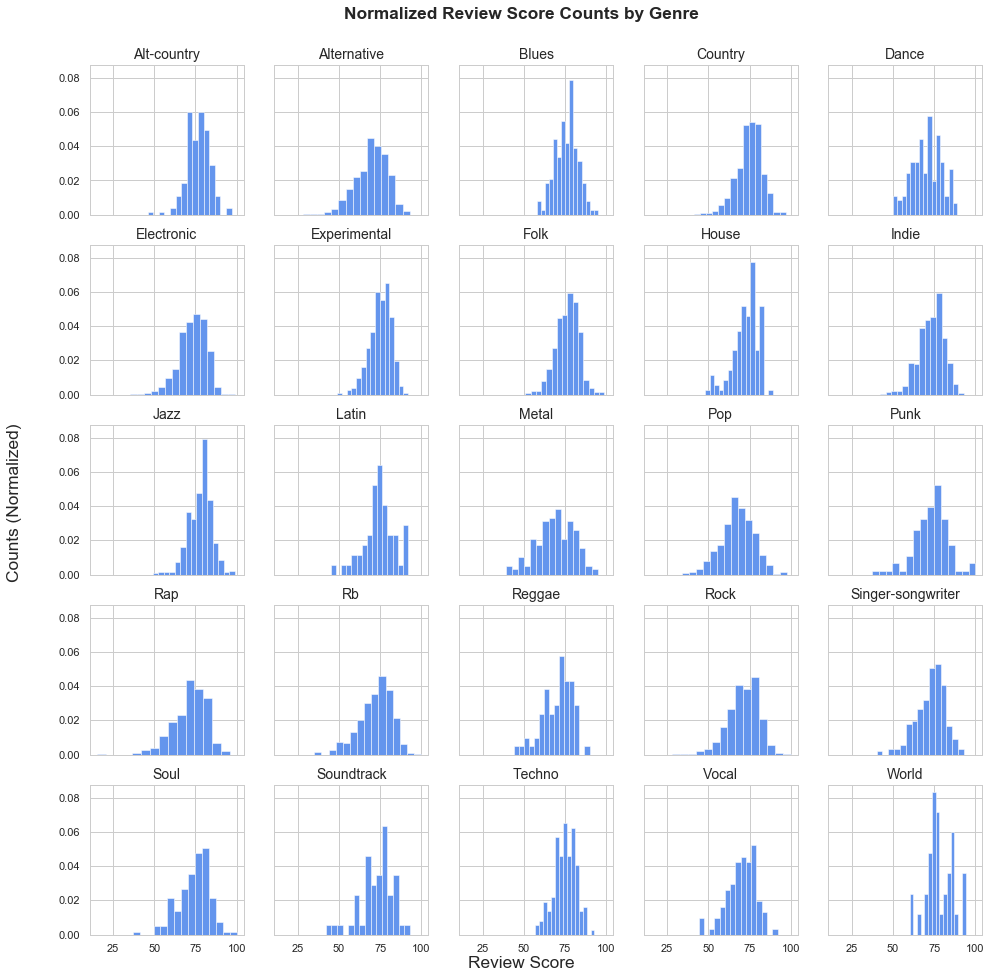

In [515]:
plot_scores(w)

In [93]:
# Create a function that provides a count of how many counts of scores each
# genre has
def count_scores(score_list):
    '''
    Given a list of name-array tuples (created in df_to_scores), this 
    function provides the count of scores in each genre 
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    
    Returns:
    score_dict (dict): dictionary of genres and respective review counts
    '''
    score_dict = {}
    for name, array in score_list:
        score_dict[name] = len(array)
        print('The {} genre has {} recorded scores'.format(name, len(array)))
    return score_dict

In [174]:
l = count_scores(w)

The alt-country genre has 161 recorded scores
The alternative genre has 1117 recorded scores
The blues genre has 155 recorded scores
The country genre has 748 recorded scores
The dance genre has 174 recorded scores
The electronic genre has 2358 recorded scores
The experimental genre has 284 recorded scores
The folk genre has 648 recorded scores
The house genre has 127 recorded scores
The indie genre has 2219 recorded scores
The jazz genre has 376 recorded scores
The latin genre has 55 recorded scores
The metal genre has 154 recorded scores
The pop genre has 928 recorded scores
The punk genre has 109 recorded scores
The rap genre has 1419 recorded scores
The rb genre has 772 recorded scores
The reggae genre has 68 recorded scores
The rock genre has 3948 recorded scores
The singer-songwriter genre has 257 recorded scores
The soul genre has 189 recorded scores
The soundtrack genre has 51 recorded scores
The techno genre has 154 recorded scores
The vocal genre has 96 recorded scores
The wo

In [303]:
# Create a function that plots histograms of our score counts
def plot_by_genre(genre, score_list):
    '''
    Given a valid genre and a score_list, this function will plot the 
    histogram of that genre and save it.
    
    Parameters:
    genre (string): name of genre to plot
    '''
    df_tup = [tup for tup in score_list if tup[0] == genre]
    name = df_tup[0][0]
    df = df_tup[0][1].values
    plt.figure(figsize=(7, 5))
    ax = sns.distplot(df, kde=False, bins = len(df)//8, color='plum')
    ax.set_title(f'Review Count for {name.capitalize()}', size = 18)
    ax.set_xlabel('Review Score', size = 14)
    ax.set_ylabel('Counts', size = 14)

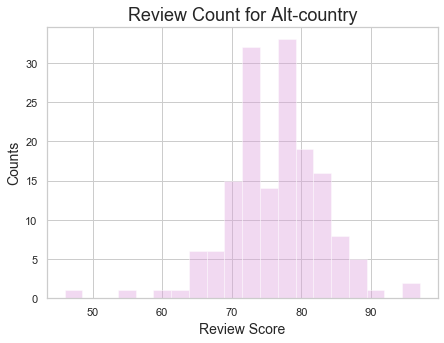

In [304]:
plot_by_genre('alt-country', w)

In [131]:
for score in w:
    print(score[0])

alt-country
alternative
blues
country
dance
electronic
experimental
folk
house
indie
jazz
latin
metal
pop
punk
rap
rb
reggae
rock
singer-songwriter
soul
soundtrack
techno
vocal
world


In [326]:
# Create a function that plots the distribution of all Metacritic scores
def plot_all_genres(score_list):
    '''
    Given a list of name-array tuples (created in df_to_scores), this 
    function plots the histogram of all reviews combined
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    
    Returns:
    all_scores (list): a list of all score values across genres
    '''
    all_scores = []
    for name, arr in score_list:
        all_scores.extend(arr.values)
    plt.figure(figsize=(7, 5))
    ax = sns.distplot(all_scores, kde=False, bins = 30, color='darkmagenta')
    ax.set_title('Review Count for All Scores', size = 18)
    ax.set_xlabel('Review Score', size = 14)
    ax.set_ylabel('Counts', size = 14)
    # I'm returning the all_scores matrix so I can do analysis on it later!
    return all_scores

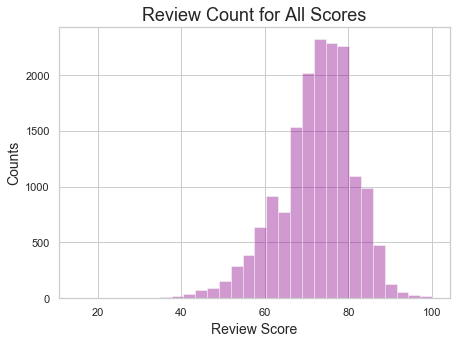

In [306]:
plot_all_genres(w)

In [307]:
# Make a plot of genre counts
def plot_genre_counts(score_dict):
    '''
    Given a dictionary of genres and review counts, this function plots the
    review count of each genre
    
    Parameters:
    score_dict (dict): dictionary of genres and respective review counts
    
    Returns:
    '''
    sorted_scores_tups = sorted(score_dict.items(), key=lambda x: x[1])
    sorted_genres = []
    for tup in sorted_scores_tups:
        sorted_genres.append(tup[0].capitalize())
    sorted_scores = []
    for tup in sorted_scores_tups:
        sorted_scores.append(tup[1])
    plt.figure(figsize=(10,6))
    ax = sns.barplot(sorted_genres, sorted_scores, palette="Blues_d")
    ax.set_title('Review Count for All Genres', size = 18)
    ax.set_xlabel('Genre', size = 14)
    ax.set_ylabel('Count of Recorded Album Reviews', size = 14)
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)

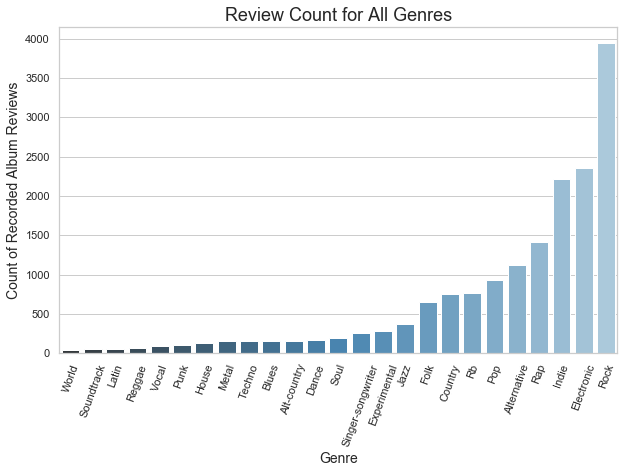

In [308]:
plot_genre_counts(l)

In [311]:
# Make a plot of genre review means
def plot_genre_means(score_list):
    '''
    Given a list of name-series tuples, this function plots the mean score
    of each genre
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    '''
    all_scores = []
    for name, arr in score_list:
        all_scores.extend(arr.values)
    genre_mean_dict = {}
    genre_mean_dict['All Genres'] = np.mean(all_scores)
    for genre, scores in score_list:
        genre_mean_dict[genre] = scores.mean()
    sorted_gm_dict = sorted(genre_mean_dict.items(), key=lambda x: x[1])
    sorted_genres = []
    for tup in sorted_gm_dict:
        sorted_genres.append(tup[0].capitalize())
    sorted_means = []
    for tup in sorted_gm_dict:
        sorted_means.append(tup[1])
    plt.figure(figsize=(10,6))    
    ax = sns.barplot(sorted_genres, sorted_means, palette='Blues_d')
    ax.set_title('Mean Album Review Scores across Genres', size = 18)
    ax.set_xlabel('Genre', size = 14)
    ax.set_ylabel('Mean of Album Reviews', size = 14)    
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)

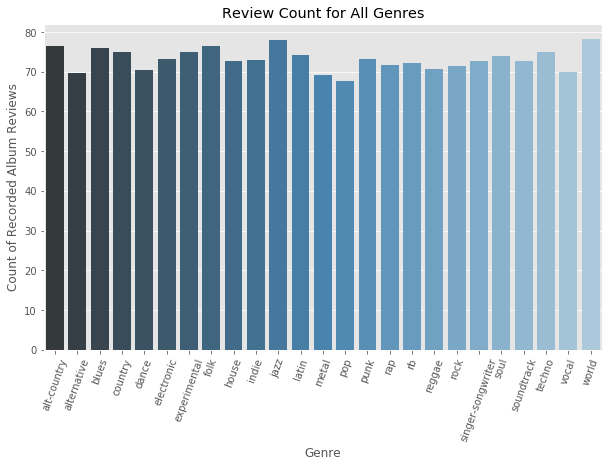

In [235]:
#for genre, scores in w:
    #print(genre)
#    print(scores.mean())
plot_genre_means(w)

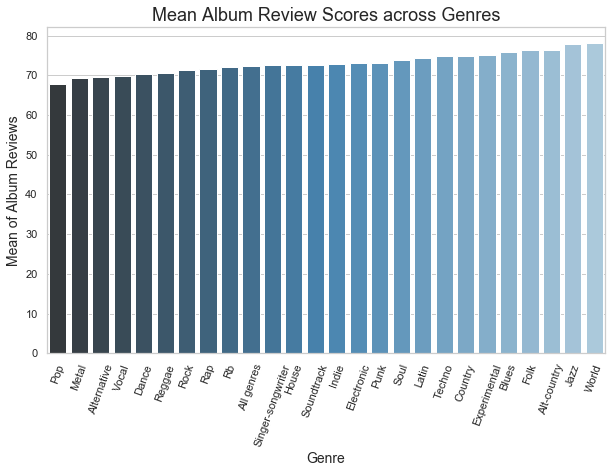

In [312]:
plot_genre_means(w)

In [313]:
# Make a plot of genre standard deviations
def plot_genre_std(score_list):
    '''
    Given a list of name-series tuples, this function plots the standard
    deviation of score for of each genre
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    '''
    genre_std_dict = {}
    for genre, scores in score_list:
        genre_std_dict[genre] = scores.std()
    sorted_std_dict = sorted(genre_std_dict.items(), key=lambda x: x[1])
    sorted_genres = []
    for tup in sorted_std_dict:
        sorted_genres.append(tup[0].capitalize())
    sorted_std = []
    for tup in sorted_std_dict:
        sorted_std.append(tup[1])
    plt.figure(figsize=(10,6))
    ax = sns.barplot(sorted_genres, sorted_std, palette="Blues_d")
    ax.set_title('Standard Deviation of Album Review Scores across Genres', 
                 size = 18)
    ax.set_xlabel('Genre', size = 14)
    ax.set_ylabel('Standard Deviation of Album Reviews', size = 14)
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)

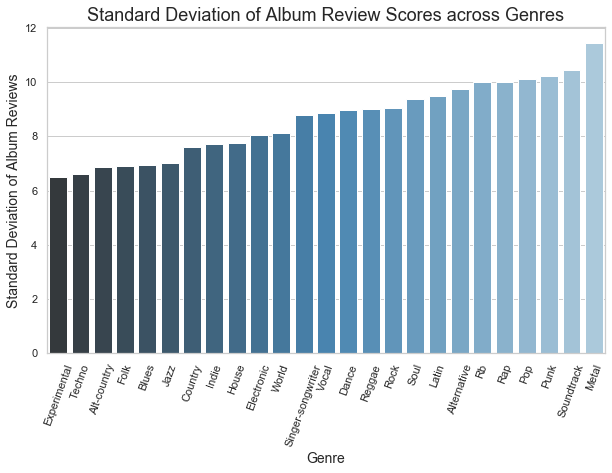

In [314]:
plot_genre_std(w)

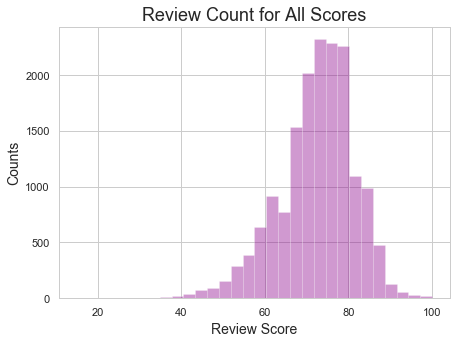

In [327]:
# How normal is our data?
allscores = plot_all_genres(w)

In [355]:
def see_normality(all_scores):
    '''
    Given a list of all Metacritic scores, this function plots a histogram,
    normal probability plot & a boxplot to assess normality
    
    Parameters:
    all_scores (list): a list of all score values across genres
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6, 16))
    sns.distplot(all_scores, kde=False, bins = 30, color='darkmagenta',
                 ax=ax1)
    ax1.set_title('Review Count for All Scores')
    ax1.set_xlabel('Review Score')
    ax1.set_ylabel('Counts')
    sns.boxplot(all_scores, showmeans=True, ax=ax2)
    ax2.set_title('Box Plot for All Review Scores')
    ax2.set_xlabel('Review Scores')
    stats.probplot(all_scores, plot=ax3)
    plt.show()

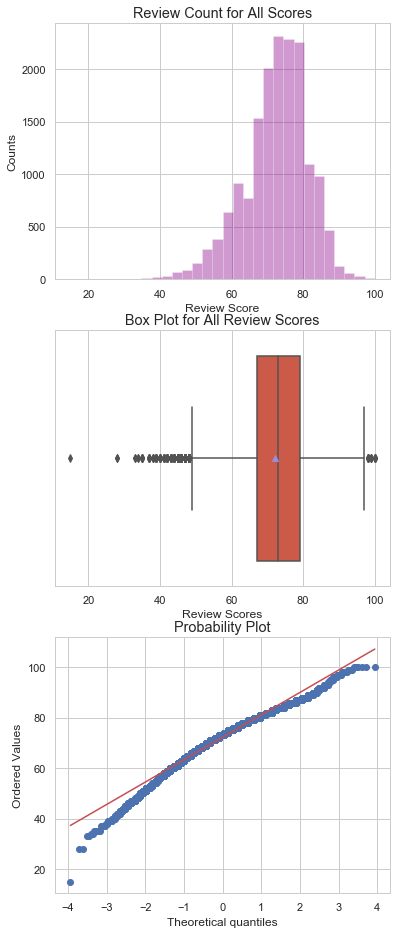

In [356]:
see_normality(allscores)

In [360]:
from itertools import combinations

In [446]:
# Run a Welch's T-test on all samples to evaluate differences.
def ttest_for_reviews(score_list, alpha = 0.05):
    '''
    Given a list of name-array tuples (created in df_to_scores), this 
    function runs a Welch's t-test between all pairs with an Bonferroni
    correction.
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    alpha (float): desired alpha for each individual t-test
    
    Returns:
    results (list of tuples): list of tuples for any t-tests that provide an
    p-value less than alpha (Bonferroni corrected)
    '''
    results = []
    bonf = alpha / len(list(combinations(score_list, 2)))
    for x, y in combinations(score_list, 2):
        name1, name2, scores1, scores2 = x[0], y[0], x[1], y[1]
        tstat, pvalue = stats.ttest_ind(scores1, scores2, equal_var = False)
        #print(f'{name1} & {name2}: p-value = {pvalue}, t-value = {tstat}')
        if pvalue < bonf:
              results.append((name1, name2))
    return results

In [447]:
results = ttest_for_reviews(w)
results

[('alt-country', 'alternative'),
 ('alt-country', 'dance'),
 ('alt-country', 'electronic'),
 ('alt-country', 'house'),
 ('alt-country', 'indie'),
 ('alt-country', 'metal'),
 ('alt-country', 'pop'),
 ('alt-country', 'rap'),
 ('alt-country', 'rb'),
 ('alt-country', 'reggae'),
 ('alt-country', 'rock'),
 ('alt-country', 'singer-songwriter'),
 ('alt-country', 'vocal'),
 ('alternative', 'blues'),
 ('alternative', 'country'),
 ('alternative', 'electronic'),
 ('alternative', 'experimental'),
 ('alternative', 'folk'),
 ('alternative', 'house'),
 ('alternative', 'indie'),
 ('alternative', 'jazz'),
 ('alternative', 'pop'),
 ('alternative', 'rap'),
 ('alternative', 'rb'),
 ('alternative', 'rock'),
 ('alternative', 'singer-songwriter'),
 ('alternative', 'soul'),
 ('alternative', 'techno'),
 ('alternative', 'world'),
 ('blues', 'dance'),
 ('blues', 'electronic'),
 ('blues', 'indie'),
 ('blues', 'metal'),
 ('blues', 'pop'),
 ('blues', 'rap'),
 ('blues', 'rb'),
 ('blues', 'reggae'),
 ('blues', 'rock')

In [448]:
numbers = [str(x) for x in range(25)]
print(len(numbers))
len(list(combinations(numbers, 2)))
print(len(results))

25
120


In [436]:
out = [item for t in results for item in t] 

In [437]:
results_dict = {}
for word in out:
    if word not in results_dict:
        results_dict[word] = 1
    else:
        results_dict[word] += 1
#results_dict
sorted_results = sorted(results_dict.items(), key=lambda x: x[1], 
                        reverse = True)
#sorted_results
results_dict['soundtrack'] = 0
results_dict

{'alt-country': 13,
 'alternative': 17,
 'dance': 9,
 'electronic': 12,
 'house': 5,
 'indie': 11,
 'metal': 11,
 'pop': 19,
 'rap': 12,
 'rb': 10,
 'reggae': 5,
 'rock': 12,
 'singer-songwriter': 6,
 'vocal': 8,
 'blues': 12,
 'country': 11,
 'experimental': 11,
 'folk': 13,
 'jazz': 18,
 'soul': 4,
 'techno': 9,
 'world': 9,
 'punk': 2,
 'latin': 1,
 'soundtrack': 0}

In [432]:
l
#sorted_counts = sorted(l.items(), key=lambda x: x[1], reverse = True)
#sorted_counts

{'alt-country': 161,
 'alternative': 1117,
 'blues': 155,
 'country': 748,
 'dance': 174,
 'electronic': 2358,
 'experimental': 284,
 'folk': 648,
 'house': 127,
 'indie': 2219,
 'jazz': 376,
 'latin': 55,
 'metal': 154,
 'pop': 928,
 'punk': 109,
 'rap': 1419,
 'rb': 772,
 'reggae': 68,
 'rock': 3948,
 'singer-songwriter': 257,
 'soul': 189,
 'soundtrack': 51,
 'techno': 154,
 'vocal': 96,
 'world': 37}

In [440]:
results_abc = sorted(results_dict.items(), key=lambda x: x[0])
abc_dict = dict(results_abc)
abc_dict

{'alt-country': 13,
 'alternative': 17,
 'blues': 12,
 'country': 11,
 'dance': 9,
 'electronic': 12,
 'experimental': 11,
 'folk': 13,
 'house': 5,
 'indie': 11,
 'jazz': 18,
 'latin': 1,
 'metal': 11,
 'pop': 19,
 'punk': 2,
 'rap': 12,
 'rb': 10,
 'reggae': 5,
 'rock': 12,
 'singer-songwriter': 6,
 'soul': 4,
 'soundtrack': 0,
 'techno': 9,
 'vocal': 8,
 'world': 9}

[13, 17, 12, 11, 9, 12, 11, 13, 5, 11, 18, 1, 11, 19, 2, 12, 10, 5, 12, 6, 4, 0, 9, 8, 9]
[161, 1117, 155, 748, 174, 2358, 284, 648, 127, 2219, 376, 55, 154, 928, 109, 1419, 772, 68, 3948, 257, 189, 51, 154, 96, 37]


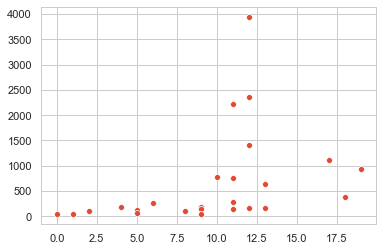

In [444]:
ax = sns.scatterplot(list(abc_dict.values()), list(l.values()))
print(list(abc_dict.values()))
print(list(l.values()))

In [501]:
# Create a function that plots two genres against one another
def compare_genres(score_list, genre1, genre2 = 'rap', alpha = 0.05):
    '''
    Given a list of name array tuples, two genres, and an alpha value, this
    function will plot the raw histogram of those genres, the normalized
    histogram of those two genres, and the distribution of their samples
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    genre1 (string): a genre of interest
    genre2 (string): a genre of interest
    alpha (float): the alpha value to be used for this test
    
    Returns:
    pvalue (float): the calculated p-value using a Welch's t-test
    '''
    df_tup1 = [tup for tup in score_list if tup[0] == genre1]
    name1 = df_tup1[0][0]
    df1 = df_tup1[0][1].values
    
    df_tup2 = [tup for tup in score_list if tup[0] == genre2]
    name2 = df_tup2[0][0]
    df2 = df_tup2[0][1].values
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6, 16))
    
    # Plot the raw histograms of two genres
    sns.distplot(df1, kde=False, bins = 20, color='plum', ax=ax1, 
                 label = f'{name1.capitalize()}')
    sns.distplot(df2, kde=False, bins = 20, color='mediumseagreen', ax=ax1, 
                 label = f'{name2.capitalize()}')
    ax1.set_title(f'Review Counts for {name1.capitalize()} and {name2.capitalize()}',
                 size = 16)
    ax1.set_xlabel('Review Score', size = 12)
    ax1.set_ylabel('Counts', size = 12)
    ax1.legend()
    
    # Plot the normalized histograms of two genres
    sns.distplot(df1, kde=False, bins = 20, color='plum', ax=ax2,
                 norm_hist = True, label = f'{name1.capitalize()}')
    sns.distplot(df2, kde=False, bins = 20, color='mediumseagreen', ax=ax2, 
                 norm_hist = True, label = f'{name2.capitalize()}')
    ax2.set_title(f'Normalized Review Counts for {name1.capitalize()} and {name2.capitalize()} ',
                 size = 16)
    ax2.set_xlabel('Review Score', size = 12)
    ax2.set_ylabel('Counts (Normalized)', size = 12)
    ax2.legend()
    
    # Plot the distributions of the samples and compare
    x = np.linspace(0, 100, 1000)
    norm1 = stats.norm(loc = np.mean(df1), scale = np.std(df1))
    norm2 = stats.norm(loc = np.mean(df2), scale = np.std(df2))

    sns.lineplot(x, norm1.pdf(x), color='plum', ax=ax3,
                 label = f'{name1.capitalize()}')
    sns.lineplot(x, norm2.pdf(x), color='mediumseagreen', ax=ax3, 
                 label = f'{name2.capitalize()}')
    ax3.set_title(f'Sample Distributions for {name1.capitalize()} and {name2.capitalize()} ',
                 size = 16)
    ax3.set_xlabel('Review Score', size = 12)
    ax3.set_ylabel('Density', size = 12)
    ax3.set_xlim(40, 100)
    ax3.axvline(x = np.mean(df1), ls = '--', label = f'Mean ({name1})',
                c = 'mediumorchid')
    ax3.axvline(x = np.mean(df2), ls = '--', label = f'Mean ({name2})',
                c = 'darkseagreen')
    ax3.legend()
    
    # Determine if there is significance in the means of our genres
    tstat, pvalue = stats.ttest_ind(df1, df2, equal_var = False)
    conf = 100 - (alpha * 100)
    print(pvalue)
    if pvalue < alpha/2:
        print(f'With {conf}% confidence, we reject the null hypothesis that these means are the same')
        return pvalue
    else:
        print(f'With {conf}% confidence, we fail to reject the null hypothesis that these means are the same')
        return pvalue

0.3673722610727912
With 95.0% confidence, we fail to reject the null hypothesis that these means are the same


0.3673722610727912

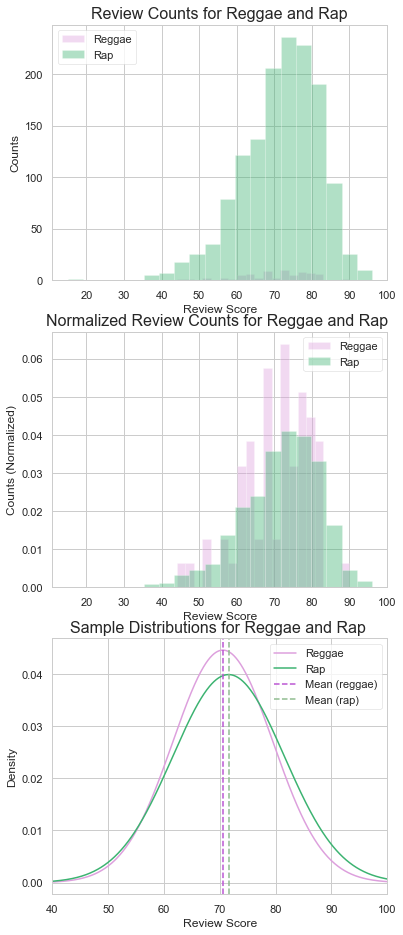

In [502]:
compare_genres(w, 'reggae')

In [487]:
for x in 
list(genre_dict.keys())

['alt-country',
 'alternative',
 'blues',
 'country',
 'dance',
 'electronic',
 'experimental',
 'folk',
 'house',
 'indie',
 'jazz',
 'latin',
 'metal',
 'pop',
 'punk',
 'rap',
 'rb',
 'reggae',
 'rock',
 'singer-songwriter',
 'soul',
 'soundtrack',
 'techno',
 'vocal',
 'world']

In [490]:
# Run a Welch's T-test on all samples to evaluate differences.
def ttest_for_rap(score_list, alpha = 0.05):
    '''
    Given a list of name-array tuples (created in df_to_scores), this 
    function runs a Welch's t-test between rap and all other genres with
    a Bonferroni correction.
    
    Parameters:
    score_list (list of tuples): list of name-series tuples
    alpha (float): desired alpha for each individual t-test
    
    Returns:
    results (list of tuples): list of tuples for any t-tests that provide an
    p-value less than alpha (Bonferroni corrected)
    '''
    diff_list = []
    same_list = []
    bonf = 24
    for tup in score_list:
        if tup[0] == 'rap':
            rap_scores = tup[1]
    for tup in score_list:
        if tup[0] == 'rap':
            continue
        else:
            tstat, pvalue = stats.ttest_ind(rap_scores, tup[1], 
                                        equal_var = False)
            if pvalue < alpha/2/bonf:
                diff_list.append(tup[0])
            else:
                same_list.append(tup[0])
    return diff_list, same_list

In [491]:
diffs, sames = ttest_for_rap(w)

In [492]:
diffs

['alt-country',
 'alternative',
 'blues',
 'country',
 'electronic',
 'experimental',
 'folk',
 'indie',
 'jazz',
 'pop',
 'techno',
 'world']

In [493]:
sames

['dance',
 'house',
 'latin',
 'metal',
 'punk',
 'rb',
 'reggae',
 'rock',
 'singer-songwriter',
 'soul',
 'soundtrack',
 'vocal']

In [506]:
sum(l.values())

16604